In [61]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from RNN_utils import *
from RNN_Model import *

import warnings
warnings.filterwarnings("ignore")

monthly = pd.read_csv('../../../Dataset/Boulder_Monthly.csv')
monthly.drop(columns={'Unnamed: 0'}, inplace=True)
monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Energy__kWh_   55 non-null     float64
 1   Month          55 non-null     object 
 2   Minimum T      55 non-null     int64  
 3   Maximum T      55 non-null     int64  
 4   Snow           55 non-null     float64
 5   Precipitation  55 non-null     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.7+ KB


## **Preprocessing**

In [62]:
train_monthly, val_monthly, test_monthly = split_dataset(monthly, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.691
Validation split ratio: 0.2
Testing split ratio:    0.109

Shapes of the datasets:
(38, 6) (11, 6) (6, 6)


    One Hot Encode

In [63]:
# One-hot encode 'Month' column for train_monthly and drop 'Month' column after one-hot encoding
train_monthly = one_hot_months(train_monthly)
train_monthly.drop(columns=['Month'], inplace=True)

# One-hot encode 'Month' column for val_monthly and drop 'Month' column after one-hot encoding
val_monthly = one_hot_months(val_monthly)
val_monthly.drop(columns=['Month'], inplace=True)

# One-hot encode 'Month' column for test_monthly and drop 'Month' column after one-hot encoding
test_monthly = one_hot_months(test_monthly)
test_monthly.drop(columns=['Month'], inplace=True)

    Create sequences for the RNNs model

In [64]:
# Define the time window size
sequence_length = 4

# Create sequences for training data
X_train, Y_train = create_sequences(train_monthly, sequence_length, 'Energy__kWh_', step=1)
# Create sequences for validation data
X_val, Y_val = create_sequences(val_monthly, sequence_length, 'Energy__kWh_', step=1)
# Create sequences for test data
X_test, Y_test = create_sequences(test_monthly, sequence_length, 'Energy__kWh_', step=1)

Dataset split into sequences:
Sequences shape: (34, 4, 17)
Targets shape: (34,)

Dataset split into sequences:
Sequences shape: (7, 4, 17)
Targets shape: (7,)

Dataset split into sequences:
Sequences shape: (2, 4, 17)
Targets shape: (2,)



**Scalling the Numerical columns**

    Scaling the X_train and Y_train

In [65]:
# We scale also with MinMaxScaler this columns ['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow']
numerical_D = len(['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow'])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# ----------------------
#    SCALE THE X_train
# ----------------------

# Extract the first 5 columns from X_train
X_train_subset = X_train[:, :, :numerical_D]

# Reshape the subset to 2D array
X_train_subset_2d = X_train_subset.reshape(-1, numerical_D)

# Fit the scaler on the subset and transform it
x_scaler = scaler.fit_transform(X_train_subset_2d)

# Reshape the scaled subset back to the original shape
X_train_scaled_subset = x_scaler.reshape(X_train.shape[0], X_train.shape[1], numerical_D)

# Combine the scaled subset with the remaining columns of X_train
X_train_scaled = np.concatenate([X_train_scaled_subset, X_train[:, :, 5:]], axis=-1)


# ----------------------
#    SCALE THE Y_train
# ----------------------

# Reshape the subset to 2D array
Y_train_reshaped = Y_train.reshape(-1,1)

# Add extra columns of zeros to match the expected dimension for concatenation
Y_train_reshaped = np.concatenate((Y_train_reshaped, np.zeros((Y_train_reshaped.shape[0], numerical_D-1))), axis=1)

# Use the previously fitted scaler to transform the Y_train_reshaped
Y_train_scaled = scaler.transform(Y_train_reshaped)

# Keep only the energy column (target) in the Y_train_scaled
Y_train_scaled = Y_train_scaled[:,:1]

    Scaling the X_val, X_test and Y_val, Y_test accord to X_train MinMaxScaler

In [66]:
X_val_scaled, Y_val_scaled = scale_data_with_fitted_scaler(scaler, X_val, Y_val, numerical_D)
X_test_scaled, Y_test_scaled = scale_data_with_fitted_scaler(scaler, X_test, Y_test, numerical_D)

print('Train Dataset:')
print("scaled X_train shape:", X_train_scaled.shape)
print("scaled Y_train shape:", Y_train_scaled.shape)

print('\nValidation Dataset:')
print("scaled X_val shape:", X_val_scaled.shape)
print("scaled Y_val shape:", Y_val_scaled.shape)

print('\nTest Dataset:')
print("scaled X_test shape:", X_test_scaled.shape)
print("scaled Y_test shape:", Y_test_scaled.shape)

Train Dataset:
scaled X_train shape: (34, 4, 17)
scaled Y_train shape: (34, 1)

Validation Dataset:
scaled X_val shape: (7, 4, 17)
scaled Y_val shape: (7, 1)

Test Dataset:
scaled X_test shape: (2, 4, 17)
scaled Y_test shape: (2, 1)


    Create the RNNs Models

In [67]:
# Define the input shape for the models ||  input_shape = (sequence_length, num_features)
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])

# Create LSTM model
# Define the default regularation l2=0.01  ||  If we want we can train the model without regularations. (regularization = 0)
lstm = RnnModel('LSTM', input_shape, num_layers=6, num_units=128, regularization=0.01)

# Create Simple RNN model
simple_rnn = RnnModel('SimpleRNN', input_shape, num_layers=3, num_units=64, regularization=0.03)

# Create Bi-LSTM model
bi_lstm = RnnModel('Bi-LSTM', input_shape, num_layers=3, num_units=64, regularization=0.01)

# Create GRU model
gru = RnnModel('GRU', input_shape, num_layers=3, num_units=64, regularization=0.01)


# Print summaries of the configurations
print("LSTM Summary:")
lstm.summary()
print()

print("Simple RNN Summary:")
simple_rnn.summary()
print()

print("Bi-LSTM Summary:")
bi_lstm.summary()
print()

print("GRU Summary:")
gru.summary()

LSTM Summary:
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 4, 128)            74752     
                                                                 
 lstm_46 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_47 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_48 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_49 (LSTM)              (None, 4, 128)            131584    
                                                                 
 lstm_50 (LSTM)              (None, 128)               131584    
                                                                 
 dense_20 (Dense)            (None, 1) 

    Compile the Models

In [68]:
# Define the learning rate for Adam optimizer
learning_rate = 0.001

# Compile each RNN model
lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

simple_rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

bi_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

    Train the Models

In [69]:
# Define the parameters for training
lstm_epochs = 100
simple_rnn_epochs, bi_lstm_epochs, gru_epochs = 200, 200, 200
batch_size = 1

# Train each RNN model
print('-----------------\nLSTM Training\n-----------------\n')
lstm_history = train_rnn_model(lstm, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, lstm_epochs, batch_size)

print('\n-----------------\nSimpleRNN / Vanilla RNN Training\n-----------------\n')
simple_rnn_history = train_rnn_model(simple_rnn, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, simple_rnn_epochs, batch_size)

print('\n-----------------\nBi-LSTM Training\n-----------------\n')
bi_lstm_history = train_rnn_model(bi_lstm, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, bi_lstm_epochs, batch_size)

print('\n-----------------\nGRU Training\n-----------------\n')
gru_history = train_rnn_model(gru, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, gru_epochs, batch_size)

-----------------
LSTM Training
-----------------



Epoch 1/100
34/34 [==============================] - 124s 522ms/step - loss: 18.3712 - mae: 0.2843 - mse: 0.1212 - root_mean_squared_error: 0.2843 - val_loss: 12.5075 - val_mae: 0.1776 - val_mse: 0.0577 - val_root_mean_squared_error: 0.1776
Epoch 2/100
34/34 [==============================] - 3s 94ms/step - loss: 9.9539 - mae: 0.2184 - mse: 0.0745 - root_mean_squared_error: 0.2184 - val_loss: 8.0687 - val_mae: 0.1773 - val_mse: 0.0572 - val_root_mean_squared_error: 0.1773
Epoch 3/100
34/34 [==============================] - 2s 59ms/step - loss: 7.2411 - mae: 0.2109 - mse: 0.0682 - root_mean_squared_error: 0.2109 - val_loss: 6.5758 - val_mae: 0.1685 - val_mse: 0.0480 - val_root_mean_squared_error: 0.1685
Epoch 4/100
34/34 [==============================] - 2s 58ms/step - loss: 6.2396 - mae: 0.2140 - mse: 0.0708 - root_mean_squared_error: 0.2140 - val_loss: 5.9009 - val_mae: 0.1702 - val_mse: 0.0492 - val_root_mean_squared_error: 0.1702
Epoch 5/100
34/34 [==============================] 

    Evaluate the Models

In [70]:
def evaluate_model(model, model_name, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    train_eval = model.evaluate(X_train, Y_train, verbose=0)
    val_eval = model.evaluate(X_val, Y_val, verbose=0)
    test_eval = model.evaluate(X_test, Y_test, verbose=0)

    print(f'\nEvaluation metrics for {model_name} model:\n-------------------')
    print('Training Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(train_eval[0], train_eval[3], train_eval[1], train_eval[2]))
    print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(val_eval[0], val_eval[3], val_eval[1], val_eval[2]))
    print('Test Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}'.format(test_eval[0], test_eval[3], test_eval[1], test_eval[2]),'\n')

evaluate_model(lstm, 'LSTM',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)
evaluate_model(simple_rnn, 'RNN',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)
evaluate_model(bi_lstm, 'Bi-LSTM',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)
evaluate_model(gru, 'GRU',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)


Evaluation metrics for LSTM model:
-------------------
Training Data - Loss: 0.0673, MAE: 0.2780, RMSE: 0.2106, MSE: 0.0663

Validation Data - Loss: 0.0522, MAE: 0.2263, RMSE: 0.1725, MSE: 0.0512

Test Data - Loss: 0.0450, MAE: 0.2098, RMSE: 0.2095, MSE: 0.0440 


Evaluation metrics for RNN model:
-------------------
Training Data - Loss: 0.0674, MAE: 0.2791, RMSE: 0.2109, MSE: 0.0665

Validation Data - Loss: 0.0529, MAE: 0.2280, RMSE: 0.1732, MSE: 0.0520

Test Data - Loss: 0.0450, MAE: 0.2101, RMSE: 0.2095, MSE: 0.0441 


Evaluation metrics for Bi-LSTM model:
-------------------
Training Data - Loss: 0.0709, MAE: 0.2817, RMSE: 0.2121, MSE: 0.0671

Validation Data - Loss: 0.0576, MAE: 0.2319, RMSE: 0.1748, MSE: 0.0538

Test Data - Loss: 0.0484, MAE: 0.2113, RMSE: 0.2095, MSE: 0.0446 


Evaluation metrics for GRU model:
-------------------
Training Data - Loss: 0.0666, MAE: 0.2756, RMSE: 0.2105, MSE: 0.0661

Validation Data - Loss: 0.0500, MAE: 0.2226, RMSE: 0.1706, MSE: 0.0496

Test D

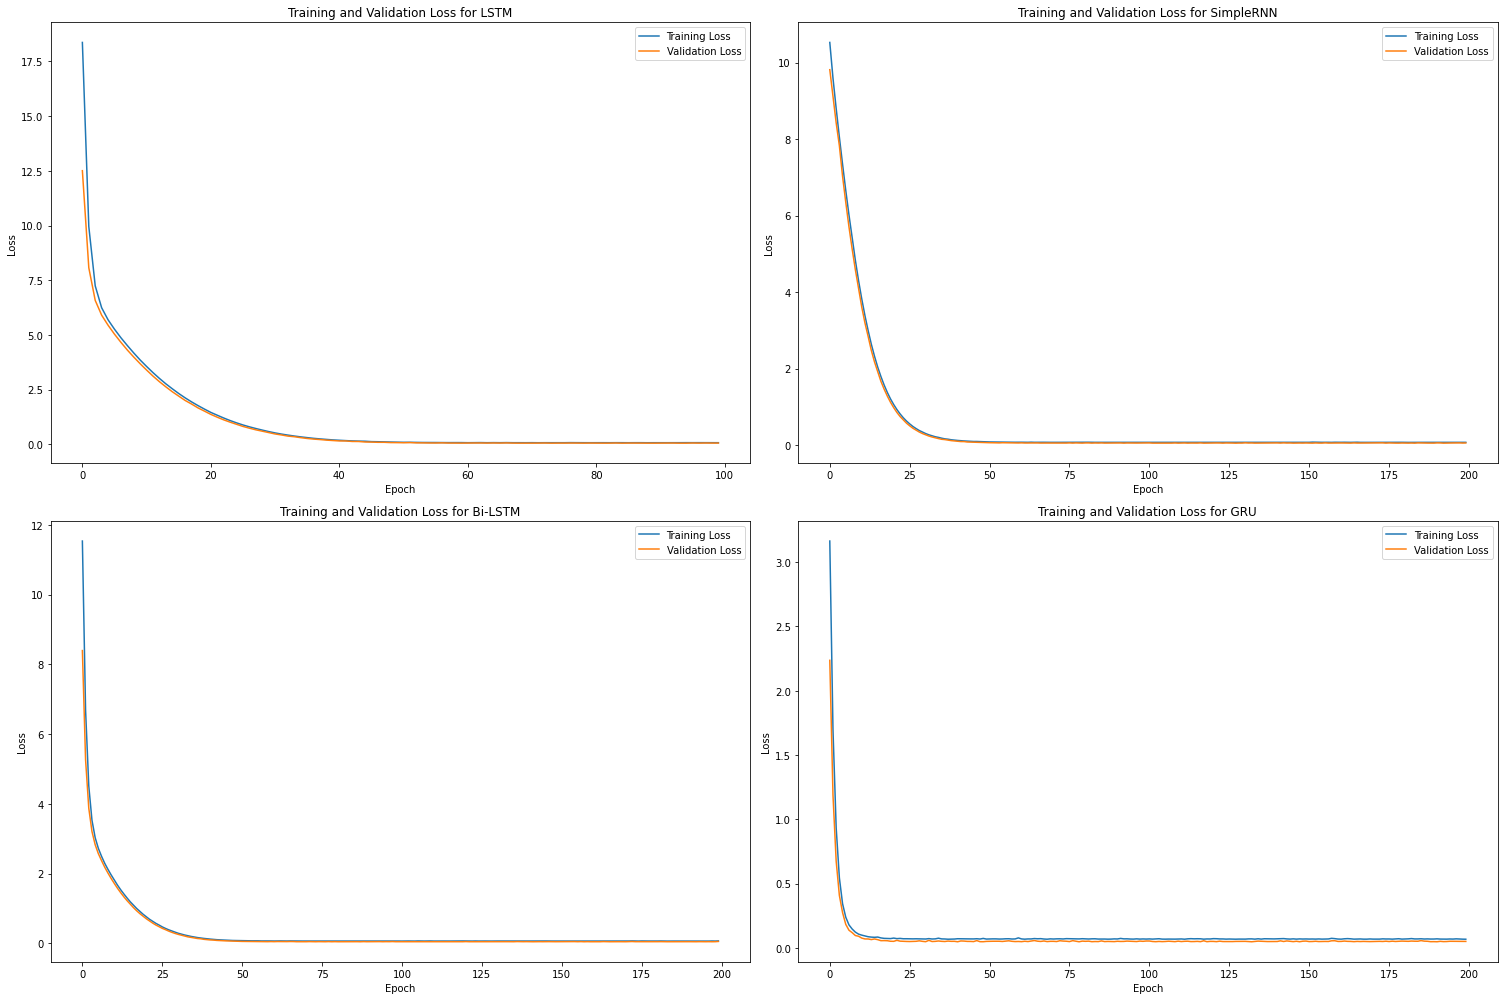

In [71]:
def plot_loss(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss for ' + model_name)
    ax.legend()


fig, axes = plt.subplots(2, 2, figsize=(21, 14))
axes = axes.flatten()

histories = []
model_names = ['LSTM', 'SimpleRNN', 'Bi-LSTM', 'GRU']
histories.extend([lstm_history, simple_rnn_history, bi_lstm_history, gru_history])

for i, (history, model_name) in enumerate(zip(histories, model_names)):
    plot_loss(history, model_name, axes[i])

# Hide empty subplots
for i in range(len(histories), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

    Make predictions with Train, Validation and Test Dataset and evaluate them with MAE and RMSE

In [72]:
evaluate_predictions_model(lstm, 'LSTM', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)
evaluate_predictions_model(simple_rnn, 'RNN', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)
evaluate_predictions_model(bi_lstm, 'Bi-LSTM', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)
evaluate_predictions_model(gru, 'GRU', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)

1/1 [==============================] - 0s 156ms/step


Evaluation metrics for LSTM model:
-------------------
Train Dataset:
RMSE: 3728.0662751811283
MAE: 3048.001794792249
-------------------
Validation Dataset:
RMSE: 3275.637220594609
Validation MAE: 2496.0538587811757
-------------------
Test Dataset:
Test RMSE: 3036.151662994492
Test MAE: 3031.6939999999995


1/1 [==============================] - 0s 187ms/step


Evaluation metrics for RNN model:
-------------------
Train Dataset:
RMSE: 3733.557991563451
MAE: 3052.5101749954465
-------------------
Validation Dataset:
RMSE: 3300.6375685384355
Validation MAE: 2507.0027821317994
-------------------
Test Dataset:
Test RMSE: 3041.266322091112
Test MAE: 3031.6939999999995


1/1 [==============================] - 0s 177ms/step


Evaluation metrics for Bi-LSTM model:
-------------------
Train Dataset:
RMSE: 3749.671076973619
MAE: 3069.529723539482
-------------------
Validation Dataset:
RMSE: 3356.7180406968837
Validation MAE: 2529.4244857